In [6]:
# import the package
import gc
import glob
import os
import json
import cv2
from joblib import Parallel, delayed
from tqdm import tqdm, tqdm_notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras import Input
from keras.applications.densenet import preprocess_input, DenseNet121
from keras.applications import VGG16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
SEED = 42

In [7]:
# load image data
images = sorted(glob.glob('data/train_images/*.jpg'))
print('Number of images files: {}'.format(len(images)))

metadata = sorted(glob.glob('data/train_metadata/*.json'))
print('Number of metadata files: {}'.format(len(metadata)))

Number of images files: 58311
Number of metadata files: 58311


In [9]:
# pet id
df = pd.read_csv('data/train/train.csv')
pet_ids = df[['PetID']]

97.73% pets have images and metadata.

In [35]:
images_df = pd.DataFrame(images)
images_df.columns = ['filename']
images_df['PetID'] = images_df.filename.apply(lambda x: x.split('/')[2].split('-')[0])
print(images_df.PetID.nunique()/len(pet_ids))

metadata_df = pd.DataFrame(metadata)
metadata_df.columns = ['filename']
metadata_df['PetID'] = metadata_df.filename.apply(lambda x: x.split('/')[2].split('-')[0])
print(metadata_df.PetID.nunique()/len(pet_ids))

0.9772560528246516
0.9772560528246516


In [36]:
# read and parse metadata
def extract_metadata(row):
    with open(row['filename'], 'r') as f:
        file = json.load(f)
        
    file_keys = list(file.keys())
        
    if 'labelAnnotations' in file_keys:
        file_annots = file['labelAnnotations'][:int(len(file['labelAnnotations']) * 0.3)]
        file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
    else:
        file_top_score = np.nan
        file_top_desc = ['']

    file_colors = file['imagePropertiesAnnotation']['dominantColors']['colors']
    file_crops = file['cropHintsAnnotation']['cropHints']

    file_color_score = np.asarray([x['score'] for x in file_colors]).mean()
    file_color_pixelfrac = np.asarray([x['pixelFraction'] for x in file_colors]).mean()

    file_crop_conf = np.asarray([x['confidence'] for x in file_crops]).mean()

    if 'importanceFraction' in file_crops[0].keys():
        file_crop_importance = np.asarray([x['importanceFraction'] for x in file_crops]).mean()
    else: file_crop_importance = np.nan

    metadata = {
        'annots_score': file_top_score,
        'color_score': file_color_score,
        'color_pixelfrac': file_color_pixelfrac,
        'crop_conf': file_crop_conf,
        'crop_importance': file_crop_importance,
    }
    
    for key, value in metadata.items():
        row['metadata_'+key] = value
        
    return row

metadata_df = metadata_df.apply(extract_metadata, axis=1)
metadata_df.head()

,filename,PetID,metadata_annots_score,metadata_color_score,metadata_color_pixelfrac,metadata_crop_conf,metadata_crop_importance
0,data/train_metadata/0008c5398-1.json,0008c5398,0.944419,0.059481,0.043881,0.8,1.0
1,data/train_metadata/0008c5398-2.json,0008c5398,0.934331,0.081809,0.060953,0.8,1.0
2,data/train_metadata/0008c5398-3.json,0008c5398,0.955835,0.084013,0.045756,0.8,1.0
3,data/train_metadata/0008c5398-4.json,0008c5398,0.932928,0.067741,0.048589,0.8,1.0
4,data/train_metadata/0008c5398-5.json,0008c5398,0.931101,0.068127,0.051458,0.8,1.0


In [48]:
# aggregate metadata by pet ID
metadata_final_df = metadata_df.drop('filename', axis=1)
metadata_agg_df = metadata_final_df.groupby('PetID').agg(['sum', 'mean', 'var'])
metadata_agg_df.columns = ['_'.join(x) for x in metadata_agg_df.columns]
metadata_agg_df.reset_index(inplace=True)
metadata_agg_df.head()

,PetID,metadata_annots_score_sum,metadata_annots_score_mean,metadata_annots_score_var,metadata_color_score_sum,metadata_color_score_mean,metadata_color_score_var,metadata_color_pixelfrac_sum,metadata_color_pixelfrac_mean,metadata_color_pixelfrac_var,metadata_crop_conf_sum,metadata_crop_conf_mean,metadata_crop_conf_var,metadata_crop_importance_sum,metadata_crop_importance_mean,metadata_crop_importance_var
0,0008c5398,5.641122,0.940187,8.753511e-05,0.427536,0.071256,9.176452e-05,0.300160,0.050027,0.000036,4.8,0.8,0.0,6.0,1.0,0.0
1,000a290e4,1.884046,0.942023,5.596608e-07,0.161713,0.080857,5.431417e-07,0.114633,0.057316,0.000122,1.6,0.8,0.0,2.0,1.0,0.0
2,000fb9572,5.654862,0.942477,3.450427e-04,0.538534,0.089756,4.634404e-05,0.389065,0.064844,0.000374,4.8,0.8,0.0,6.0,1.0,0.0
3,0011d7c25,2.793139,0.931046,1.128461e-04,0.251597,0.083866,1.071002e-04,0.227523,0.075841,0.000050,2.4,0.8,0.0,3.0,1.0,0.0
4,00156db4a,4.635251,0.927050,7.186672e-04,0.418022,0.083604,3.871732e-05,0.288098,0.057620,0.000378,4.0,0.8,0.0,5.0,1.0,0.0


In [49]:
metadata_agg_df.to_csv('data/metadata.csv')

## Extract Image Feature

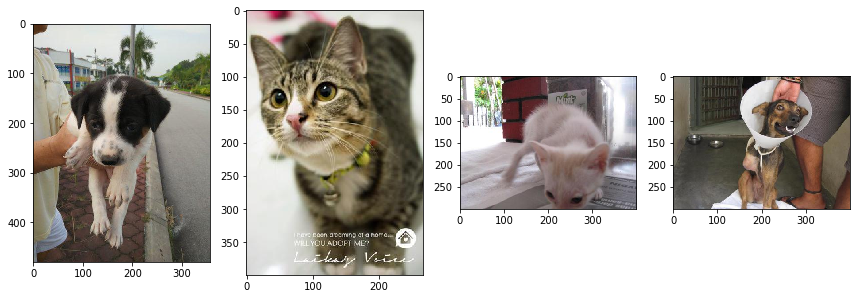

In [2]:
def load_images(folder):
    images = {}
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if RGB_img is not None:
            images[filename.split('.')[0]] = RGB_img
    return images

pet_images = load_images('data/train_images')
 
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(pet_images[list(pet_images.keys())[i]])
    plt.tight_layout()
plt.show()

In [14]:
img_size = 256
batch_size = 16

In [5]:
def resize_to_square(im):
    old_size = im.shape[:2]
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

def load_image(path, pet_id):
    image = cv2.imread(f'{path}{pet_id}-1.jpg')
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image

In [32]:
inp = Input((256,256,3))
densenet121 = DenseNet121(input_tensor = inp, include_top = False)
densenet121.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [7]:
x = densenet121.output
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
x = AveragePooling1D(4)(x)
out = Lambda(lambda x: x[:,:,0])(x)

m = Model(inp,out)

In [23]:
pet_ids = df['PetID'].values
n_batches = len(pet_ids)//batch_size + 1

features = {}
for b in tqdm_notebook(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size
    batch_pets = pet_ids[start:end]
    batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
    for i, pet_id in enumerate(batch_pets):
        try:
            batch_images[i] = load_image('data/train_images/', pet_id)
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i, pet_id in enumerate(batch_pets):
        features[pet_id] = batch_preds[i]

In [24]:
image_features = pd.DataFrame.from_dict(features, orient='index')

In [27]:
image_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
86e1089a3,0.002000,0.167800,0.019715,0.015896,0.068162,0.002216,0.005042,0.004828,0.050760,0.047626,0.128123,0.002644,0.008419,0.002939,0.020522,0.027410,0.003088,0.012169,0.003333,0.000998,0.018632,0.077649,0.339404,0.002820,0.257835,0.104672,0.310306,0.003270,0.006633,0.090423,0.019694,0.155205,0.075269,0.110293,0.240876,0.144366,0.018792,0.024890,1.037702,0.008969,0.097524,0.081323,0.120779,0.001018,0.019577,0.007865,0.002842,0.017222,0.007129,0.097833,...,0.550724,2.526067,0.791681,0.540068,0.587223,0.363273,1.015185,0.382411,0.471457,0.545445,1.029138,1.248022,0.775702,0.776602,0.643537,1.337169,1.232706,0.598950,0.525196,0.452153,0.490508,1.022438,0.614807,0.541663,0.618360,0.905439,1.570455,1.062894,0.817880,0.746038,0.492369,0.881878,0.412291,0.338275,1.598082,1.337702,0.150102,1.081104,1.282496,0.643566,0.787699,0.176626,0.575706,1.088628,0.439556,0.520460,1.547071,0.832573,0.599093,0.763348
6296e909a,0.002858,0.107450,0.019916,0.023482,0.174765,0.002297,0.005031,0.006338,0.083378,0.049948,0.161074,0.004988,0.006973,0.005427,0.008900,0.023822,0.001840,0.012856,0.002679,0.000974,0.046827,0.102511,0.211887,0.001902,0.562680,0.072588,0.220958,0.002643,0.004700,0.071769,0.004385,0.081700,0.162420,0.133753,0.441881,0.100560,0.006953,0.010209,0.390618,0.006302,0.121734,0.063919,0.202202,0.001959,0.023157,0.010383,0.002413,0.004493,0.008783,0.120349,...,0.495777,0.894064,0.611556,1.215061,1.067613,1.272729,0.701897,1.528878,0.951013,0.453231,1.001352,0.394828,1.865699,0.844213,1.675210,1.291509,0.755713,0.798778,0.562951,0.372133,0.600622,0.422987,0.657139,0.394594,0.694213,1.172009,0.694336,0.490904,0.490693,1.616012,0.207166,0.783139,0.854982,0.921905,1.477516,1.944073,0.481492,0.977005,1.295760,0.751895,0.628259,0.686865,0.564000,0.968190,1.070276,1.545742,0.894409,0.838595,0.468238,0.916672
3422e4906,0.002734,0.072015,0.024455,0.018021,0.154207,0.001946,0.004211,0.001576,0.100046,0.039717,0.119719,0.003022,0.007156,0.002907,0.011032,0.005415,0.001811,0.038851,0.002130,0.001206,0.023566,0.115429,0.311247,0.003179,0.103643,0.241490,0.305746,0.002378,0.006677,0.131081,0.003927,0.325015,0.071831,0.080980,0.326447,0.267301,0.024806,0.025080,0.998322,0.014181,0.172482,0.043071,0.076429,0.002347,0.018067,0.006656,0.001920,0.015665,0.002854,0.146055,...,0.921158,1.027861,0.298314,1.065685,0.785238,0.652861,0.355817,0.384520,0.202977,0.455028,1.688117,0.649631,0.886553,1.136400,0.614208,1.170582,0.379828,0.557486,0.487180,0.371101,0.357815,0.413768,1.824433,0.107984,0.207773,0.527613,1.305410,0.512335,0.412740,0.527163,0.542680,0.880279,0.761983,0.951313,0.991607,0.705539,0.793940,0.469397,0.278331,1.043843,0.579116,0.557625,1.131405,0.720513,1.496671,0.870955,1.289683,1.184462,0.465114,0.892826
5842f1ff5,0.002106,0.274519,0.054815,0.013727,0.089969,0.001650,0.005506,0.004295,0.118727,0.034790,0.334318,0.002197,0.003880,0.003094,0.012323,0.013766,0.001426,0.015739,0.003654,0.001391,0.019650,0.097436,0.129095,0.002895,0.201020,0.174797,0.169937,0.002312,0.005421,0.079292,0.017054,0.053951,0.037197,0.089977,0.309167,0.177141,0.018449,0.021084,0.868292,0.022003,0.155791,0.093217,0.081609,0.001084,0.013675,0.013071,0.002251,0.012105,0.005751,0.179021,...,0.886083,1.005002,1.578772,1.078160,1.112259,0.474224,0.764847,1.445761,0.898221,0.396363,1.497689,1.402908,0.392422,0.869897,0.534949,0.995044,0.597004,0.784653,0.671365,0.296617,1.206261,0.822870,1.111003,0.146424,0.739725,0.477510,1.086609,0.529818,1.399652,0.731581,0.347766,0.992342,0.693935,1.257455,1.006487,1.690940,1.246175,0.743013,1.178627,0.865275,1.295853,0.326143,0.291669,1.608086,1.119176,1.470889,0.591444,0.832755,0.483021,1.134126

In [26]:
image_features.to_csv('data/img_features.csv')